# **PCLab#2 - Group 2 - Morresi Masia Valdo**

This is the **second PC lab** of group 2. The context involves our recent hiring at a small hedge fund. We're moving from passive investing, now focusing on returns rather than investment size. Our task is to calculate the systemic risk (beta) for 8 stocks, and our broker offers fee-free transactions. This exercise is a chance to analyze risk and portfolios while understanding *systemic risk*.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import normaltest

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('./data/Data_PCLab1_Stock.csv')
data.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
1,2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2,2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
3,2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
4,2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


In [ ]:
stocks = list(data.drop(['Date', 'sp500'], axis=1).columns)

print('Number of stocks: ', len(stocks))
print('Stocks: ', stocks)

Number of stocks:  8
Stocks:  ['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']


# Task #1
*Produce a scatter plot of each stock*

We define a function called `compute_returns()` which computes the returns of a stock given its price history from a Pandas DataFrame. The function creates a new dataframe with the same index as the input dataframe, but each column displays the *daily* returns of the corresponding stock.

The daily returns are computed as the logarithm of the ratio between the price of the current day and the price of the previous day. This method, even though representing an approximation, allows us to contain large values.

Then we add the date column taken from the original database and we set it as the first column of the dataframe.

In [ ]:
def compute_returns(df):
    returns_df = np.log(df.drop(['Date'], axis=1)/df.drop(['Date'], axis=1).shift(1))
    returns_df['Date'] = df['Date'] # Attach the date column to the new dataframe
    returns_df.insert(0, 'Date', returns_df.pop('Date')) # Move the date column to the first column
    return returns_df

In [ ]:
returns_df = compute_returns(data)
returns_df.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-13,-0.003757,-0.012125,-0.001661,0.017974,0.014054,-0.007728,-0.214772,-0.007413,-0.004960
2,2012-01-17,0.011581,0.008542,0.005968,-0.008130,0.017997,0.004678,0.154589,0.005728,0.003547
3,2012-01-18,0.010330,-0.002395,0.002641,0.038435,0.041936,0.005927,0.007864,0.006865,0.011047
4,2012-01-19,-0.003174,0.006639,0.002963,0.005484,0.026103,-0.003042,-0.001867,0.010468,0.004927


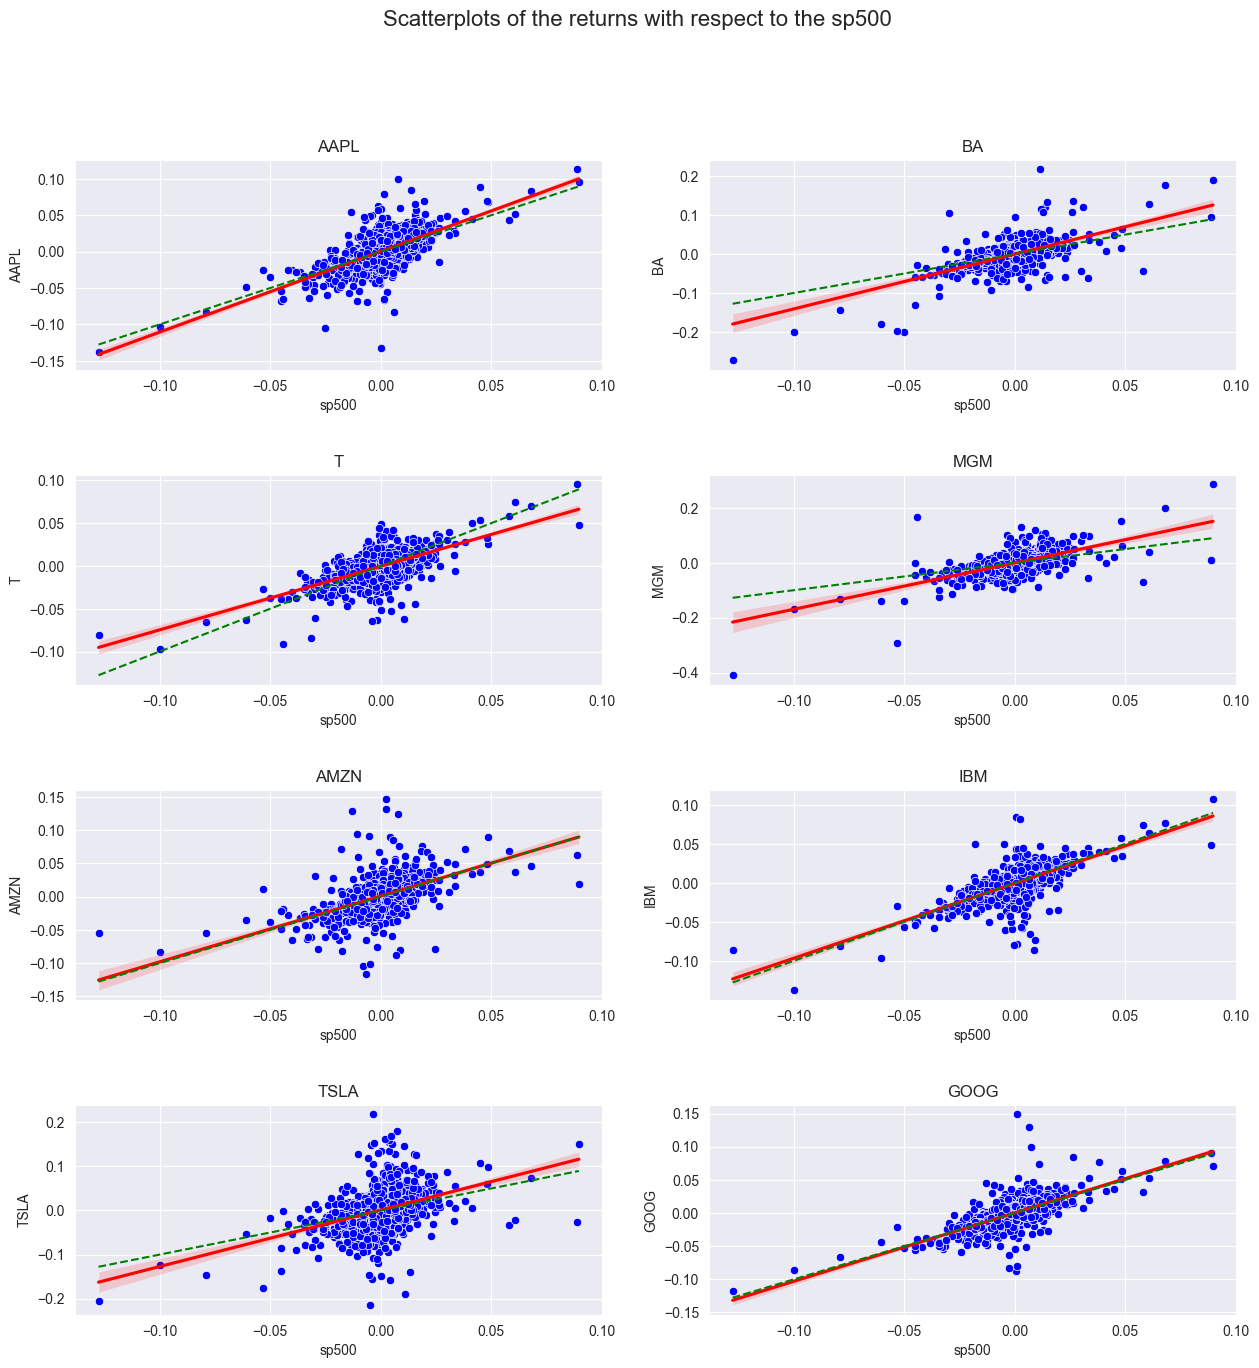

In [ ]:
# Plot the scatterplots of the returns with respect to the sp500

sns.set_style('darkgrid')

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Scatterplots of the returns with respect to the sp500', fontsize=16)

for i, col in enumerate(returns_df.columns[1:-1]):
    sns.scatterplot(x='sp500', y=col, data=returns_df, ax=axes[i//2, i%2], color='blue')
    sns.regplot(x='sp500', y=col, data=returns_df, ax=axes[i//2, i%2], color='red', scatter=False)
    sns.lineplot(x='sp500', y='sp500', data=returns_df, ax=axes[i//2, i%2], color='green', linestyle='--') # Plot the 45 degree line

    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('sp500')
    axes[i//2, i%2].set_ylabel(col)

plt.show()

In this graph we plotted the prices of each stock over time with respect to the S&P500, assumed to be the market portfolio for this CAPM application.

To better understand the correlation between each stock and the market, we also plotted the linear regression line for each stock using the function `regplot()` from the `seaborn` library. To measure the correlation we also added the 45 degree line to the graph (in green).

We can see that *Amazon*, *IBM* and *Google* have the **highest correlation** with the S&P500, followed by Apple and Tesla. This is expected since these companies are the *most valuable* in the world and are part of the S&P500 index. In fact, the S&P500 have a large amount of these companies in its portfolio.

For a deeper and proper analysis of the correlation between each stock and the market, we should compensate the effects of the weights of each stock in the S&P500 index. However, this is out of the scope of this project.

# Task #2

Compute alpha and beta of the stocks

## Apply the CAPM

*Apply the CAPM : run an OLS regression of stock i returns on market returns,
over the whole period. Assume $r_f = 0$. Are the estimates significant ?*

Recalling that the CAPM model is defined as: $$r_i-r_f = \alpha_i + \beta_i (r_m-r_f) + \epsilon_i$$ where:
- $r_i$ is the return of the stock $i$;
- $r_f$ is the risk-free rate;
- $r_m$ is the return of the market portfolio;
- $\alpha_i$ is the intercept of the linear regression line;
- $\beta_i$ is the slope of the linear regression line;
- $\epsilon_i$ is the error term.

In this model we assume that the risk-free rate is zero and that the market portfolio is the S&P500 index.

We define a function called `compute_ba()` which takes as input a dataframe containing the daily returns of stocks and the daily returns of the market portfolio.

The function iterates over each stock of the dataset (except the date and the market portfolio) and computes the **alpha** (intercept) and the **beta** (slope) of the linear regression line between the stock and the market portfolio. The **p-values** are stored in a dictionary, together with the alpha and beta values.

Before fitting the model, we drop the first row the **X** and the **Y** are since are NaN values, generated by computation of the returns.

In [ ]:
def compute_ba(df, rf=0):

    # Compute the alpha, beta and significancy of each stock with respect to the sp500
    alpha = {}
    beta = {}
    significant_a = {}
    significant_b = {}

    rf = rf/252 # Convert the risk free rate to a daily rate

    for col in df.columns[1:-1]: # Exclude the date and sp500 columns

        # Create the x and y variables
        x = sm.add_constant(df['sp500'].iloc[1:] - rf)
        y = df[col].iloc[1:] - rf

        # Create the model
        model = sm.OLS(y, x).fit()

        # Save the alphas and the betas
        alpha[col] = model.params['const']
        beta[col] = model.params['sp500']

        # Save the significancy of the regression
        significant_b[col] = model.pvalues['sp500']
        significant_a[col] = model.pvalues['const']

    reg_df = pd.DataFrame([alpha,significant_a, beta, significant_b], index=['Alpha','pvalue_alphas', 'Beta', 'pvalue_betas']).T

    return alpha, beta, significant_a, significant_b, reg_df

In [ ]:
alpha, beta, significant_a, significant_b, reg_df = compute_ba(returns_df)

We also define a function called `significancy()` which takes as input a column of a dataframe. The function is applied to the dataframe containing the p-values using the `apply()` function. The function returns a string which is either "Significant" or "Not significant" depending on the value of the p-value for each row.

In [ ]:
def significancy(x):
    if x < 0.05:
        return 'Significant'
    else:
        return 'Not significant'

In [ ]:
reg_df['Significancy_betas'] = reg_df['pvalue_betas'].apply(significancy)
reg_df['Significancy_alphas'] = reg_df['pvalue_alphas'].apply(significancy)
reg_df

,Alpha,pvalue_alphas,Beta,pvalue_betas,Significancy_betas,Significancy_alphas
AAPL,0.000433,0.133979,1.110351,1.242261e-267,Significant,Not significant
BA,-0.000213,0.565740,1.406125,6.005697e-262,Significant,Not significant
T,-0.000324,0.132272,0.743541,2.413072e-226,Significant,Not significant
MGM,-0.000475,0.301191,1.690208,4.283835e-250,Significant,Not significant
AMZN,0.000894,0.010069,0.988403,8.124414e-166,Significant,Significant
IBM,-0.000585,0.008017,0.960252,4.644217e-322,Significant,Significant
TSLA,0.001238,0.066694,1.283591,3.688526e-82,Significant,Not significant
GOOG,0.000267,0.279814,1.033036,7.158408e-304,Significant,Not significant


Beta in finance is a measure of a *stock's volatility* compared to the overall market. A beta greater than 1 signifies a stock's higher volatility than the market, indicating a more cyclical and volatile nature.

On the contrary, a beta less than 1 indicates lower volatility compared to the market, representing a more stable and less cyclical stock. The p-values close to zero, indicating the statistical significance of betas, suggest that the calculated betas reliably capture the stock's volatility concerning the market. Regarding alpha, a significant value implies that the investment's returns deviate from what is expected based on its beta and the market's expected return.

On the other hand, an insignificant alpha suggests that the investment's return *aligns well with its beta and the broader market movements*, without evidence of additional performance beyond market influence.

## Plot the alphas and betas

*Plot the beta and alpha for the 8 stocks. Which stock has the highest (lowest) beta and alpha ? Comment !*

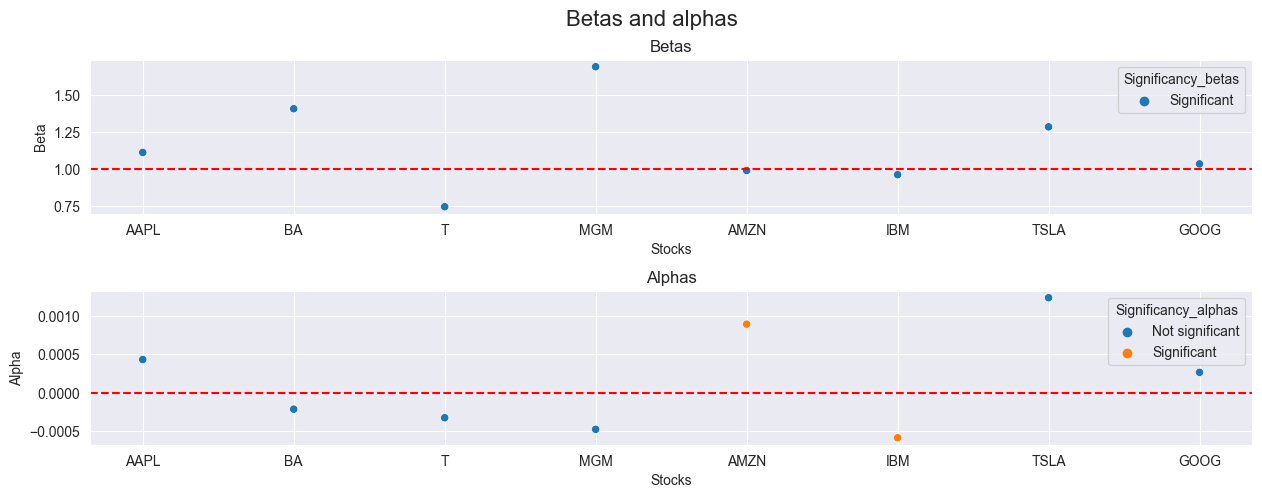

In [ ]:
# Plot of the betas and the alphas using the colors to show the significancy

sns.set_style('darkgrid')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Betas and alphas', fontsize=16)

# Betas
sns.scatterplot(x=reg_df.index, y='Beta', hue='Significancy_betas', data=reg_df, ax=axes[0])
axes[0].axhline(1, color='red', linestyle='--')
axes[0].set_title('Betas')
axes[0].set_xlabel('Stocks')
axes[0].set_ylabel('Beta')

# Alphas
sns.scatterplot(x=reg_df.index, y='Alpha', hue='Significancy_alphas', data=reg_df, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Alphas')
axes[1].set_xlabel('Stocks')
axes[1].set_ylabel('Alpha')

plt.show()

As mentioned before, here we can see that even though all betas are statistically significant, only two alphas are significantly different from zero: Amazon and IBM.

This means that the CAPM model is not a good fit for the two stocks, in fact it is no possible to explain the returns of these stocks using the returns of the market portfolio and their risk.

On the other hand, the other stocks have alphas which are different from zero, meaning that there is a possible for arbitrages in the market, according to the CAPM theory.

Almost all betas are larger than 1, meaning that the stocks are more volatile than the market (as expected). Only the beta of AT&T is smaller than 1, meaning that the stock is less volatile than the S&P500. The highest beta is that of MGM, followed by Boeing and Tesla.


Tesla demonstrates the highest alpha, pointing to outstanding performance. Despite a low beta indicating lower market volatility, Tesla consistently achieves high returns. This suggests *minimal idiosyncratic risk* and a *low correlation with the market* while delivering *impressive returns*. On the other hand, IBM shows the lowest alpha, implying *underperformance* and *potential value destruction*, possibly due to a return on invested capital lower than the cost of capital. Shifting to beta, MGM holds the highest beta, making it *highly cyclical*, likely due to its business sensitivity to economic cycles in the entertainment and hospitality industry. On the flip side, AT&T, boasts the lowest beta, highlighting *stability* and *resilience*. Given its essential role in society, the telecom industry remains vital regardless of economic cycles, resulting in a low beta.

## Residuals

*Use the observed returns and the predicted ones to compute and plot the histogram of error terms ϵi for each stock. Comment !*

Now it is time to analyze the error terms of the linear regression model.

At first we compute the error terms of the linear regression model for each stock. The residuals are obtained by subtracting the predicted values from the actual values of the stock.
$$\epsilon_i = r_i - \hat{r_i}, \quad\text{where } \hat{r_i}= \alpha_i + \beta_i r_m$$

We plot the distribution of the error terms for each stock using the `distplot()` function from the `seaborn` library. We can see that the error terms seem to be normally distributed, with a mean close to zero.

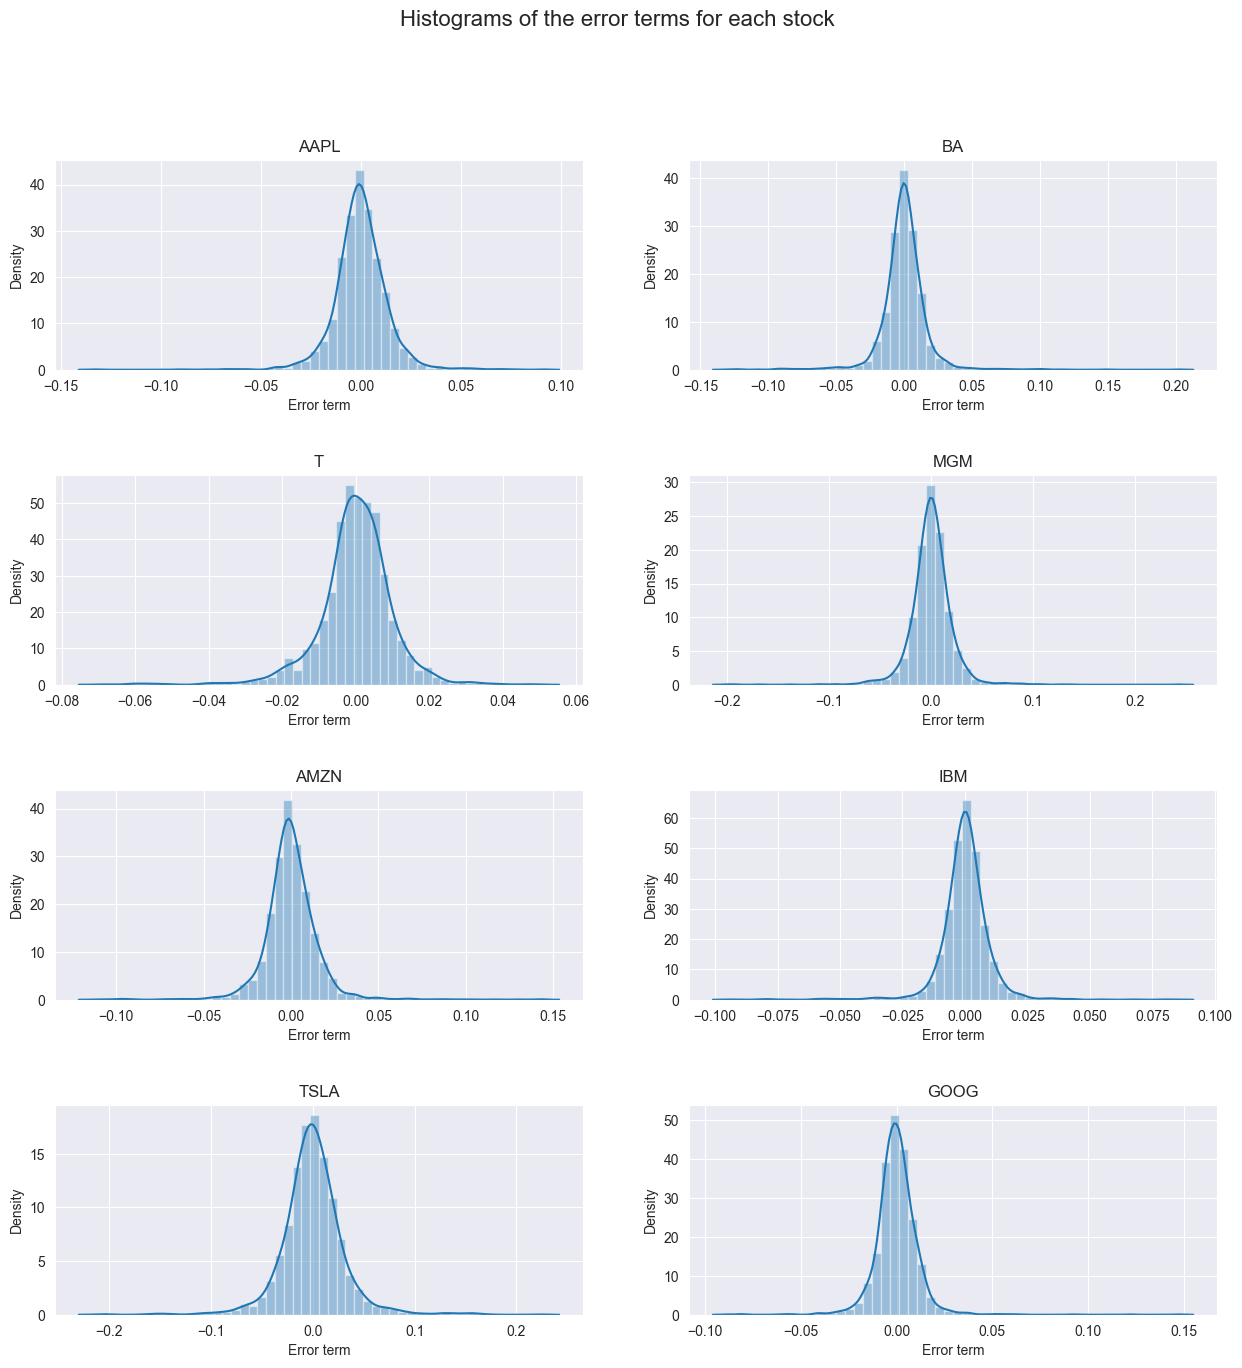

In [ ]:
# Compute the histograms of the error terms for each stock

sns.set_style('darkgrid')

# Plot the histograms of the error terms for each stock in a 4x2 grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Histograms of the error terms for each stock', fontsize=16)

residuals = {}

for i, col in enumerate(returns_df.columns[1:-1]):

    residual = returns_df[col] - returns_df['sp500']*beta[col] - alpha[col]
    residuals[col] = residual

    sns.distplot(residual, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('Error term')
    axes[i//2, i%2].set_ylabel('Density')

plt.show()

However, to be completely sure of the results drawn from the previous graphs we should perform a statistical test to check if the error terms are normally distributed.

This can be done by using the `normaltest()` function from the `scipy.stats` library. The function returns the p-value of the test. If the p-value is smaller than 0.05, we can reject the null hypothesis that the error terms are normally distributed.

In [ ]:
# Perform the normality test on the residuals

normality = {}

for col in residuals.keys():
    normality[col] = normaltest(residuals[col].iloc[1:])

normality_df = pd.DataFrame(normality, index=['Statistic', 'p-value']).T
normality_df['Significancy'] = normality_df['p-value'].apply(significancy)
normality_df

,Statistic,p-value,Significancy
AAPL,415.879713,4.930236e-91,Significant
BA,644.998257,8.717823e-141,Significant
T,516.562502,6.758928e-113,Significant
MGM,555.206882,2.743831e-121,Significant
AMZN,684.563949,2.232684e-149,Significant
IBM,827.851300,1.715435e-180,Significant
TSLA,341.349037,7.533529e-75,Significant
GOOG,989.261978,1.529294e-215,Significant


So, they are not normally distributed.

It implies that the model *may have some limitations* in capturing the complexity of the economic reality. In economic terms, this non-normal distribution could suggest that there are unaccounted factors or variables influencing stock returns beyond what the model has considered.

## Find the four riskiest assets

*Your boss wants to take a lot of risk to deliver high return. He asks you to (i) select the 4 riskiest assets (over the full period) (ii) form an equally weighted portfolio, (iii) to estimate the portfolio return based on parameters (β and rm) estimated above.*

1. We select the four riskiest assets by sorting the dataframe containing the betas in descending order and selecting the first four rows.

In [ ]:
# Find the four riskiest stocks
most_risky = reg_df.sort_values(by='Beta', ascending=False).head(4).index

print(f'The four most risky stocks are: {most_risky}.')

The four most risky stocks are: Index(['MGM', 'BA', 'TSLA', 'AAPL'], dtype='object').


2. First we compute the expected returns of each stock using the CAPM model: $$\hat{r_i} = \alpha_i + \beta_i r_m$$

In [ ]:
# Compute the expected annual returns of the four most risky stocks
annual_returns = {}
rm = returns_df['sp500'].mean()*252
rf = 0
for col in most_risky:
    annual_returns[col] = beta[col]*(rm-rf) + alpha[col]

annual_returns_df = pd.DataFrame(annual_returns, index=['Expected annual return']).T
annual_returns_df

,Expected annual return
MGM,0.186079
BA,0.154986
TSLA,0.142912
AAPL,0.122986


Write that the alphas are not significant so they could be excluded from the computation of the residuals.

3. Computing the returns of the equally weighted portfolio is straightforward. We just need to compute the average of the returns of each stock.

In [ ]:
print(f'The return of the equally weighted portfolio of the four most risky stocks is {annual_returns_df.mean()[0]:.2%}')

The return of the equally weighted portfolio of the four most risky stocks is 15.17%


# Task #3

*Testing the CAPM theory*

The goal of this last part is to test the CAPM model predictions
1. For each year : compute $β^{y−1}_i$ over 252 business days at the end of each year $y − 1$ (OLS regression);
2. At the end or year y, compare the average return of the stock $\bar r^y_i$ (annualized) to the one predicted by the CAPM model $\hat r^y_M$ (using $β^{y−1}_i$ measured at $y − 1$ but the average market return $\bar r^y_M$ measured at $y$);

In [ ]:
# Estimate the betas using a yearly dataframe

returns_df.Date = pd.to_datetime(returns_df.Date)

expected_returns = pd.DataFrame()
real_returns = pd.DataFrame()

years = returns_df.Date.dt.year.unique()[1:]

for year in years:

    # Compute the expected returns for the year
    returns_year_df = returns_df[returns_df.Date.dt.year == year -1]

    # rf is assumed to be 0
    alpha, beta, significant_a, significant_b, reg_df = compute_ba(returns_year_df)
    rm = returns_year_df['sp500'].mean()*252

    estimated_rets = (np.array(list(beta.values())) * rm + np.array(list(alpha.values())))
    expected_returns[year] = pd.Series(estimated_rets, index=returns_year_df.columns[1:-1]) # Append the column to the dataframe and set the name

    # Compute the actual return for the following year
    returns_next_year_df = returns_df[returns_df.Date.dt.year == year].drop('Date', axis=1)
    real_rets = returns_next_year_df.mean() * 252 # Annualize the returns
    real_returns[year] = real_rets


expected_returns = expected_returns.T.reset_index().rename(columns={'index': 'Year'})
real_returns = real_returns.T.reset_index().rename(columns={'index': 'Year'})

In [ ]:
real_returns

,Year,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2013,0.052794,0.593975,0.042115,0.703404,0.463500,-0.020997,1.490968,0.460150,0.259292
1,2014,0.320083,-0.048871,-0.045681,-0.095395,-0.250734,-0.156232,0.391025,-0.061510,0.107873
2,2015,-0.047495,0.106522,0.024119,0.060790,0.778330,-0.153424,0.076158,0.368524,-0.007293
3,2016,0.095604,0.073900,0.211862,0.238171,0.103869,0.187431,-0.116154,0.016908,0.091074
4,2017,0.380732,0.641413,-0.090087,0.147425,0.446177,-0.079062,0.377891,0.305572,0.178183
5,2018,-0.070591,0.089789,-0.310405,-0.320700,0.251224,-0.301074,0.066889,-0.010406,-0.064659
6,2019,0.621440,0.010058,0.314304,0.315827,0.207240,0.164839,0.228729,0.255453,0.253697
7,2020,0.652399,-0.969516,-0.421804,-0.714442,0.836394,-0.091508,1.946446,0.166606,0.051310


In [ ]:
expected_returns

,Year,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
0,2013,0.128268,0.102147,0.061935,0.172444,0.112682,0.085586,0.162016,0.086222
1,2014,0.154372,0.253535,0.192674,0.391203,0.331555,0.193053,0.311782,0.245445
2,2015,0.090145,0.110753,0.060532,0.161468,0.158273,0.077144,0.206090,0.138194
3,2016,-0.008463,-0.006841,-0.005168,-0.010482,-0.005026,-0.008051,-0.007922,-0.006371
4,2017,0.093241,0.110801,0.044335,0.153403,0.098439,0.085618,0.106420,0.085880
5,2018,0.249206,0.179958,0.133627,0.253457,0.234579,0.116682,0.243985,0.223035
6,2019,-0.080793,-0.084115,-0.044392,-0.088384,-0.103277,-0.063601,-0.087521,-0.088308
7,2020,0.398635,0.247608,0.146370,0.337457,0.335337,0.272730,0.333071,0.325807


3. Generate the scatter plot of the realized returns against the beta or find innovative ways to plot you results.
4. Alternatively, you may use a β computed over longer (shorter) periods of time.

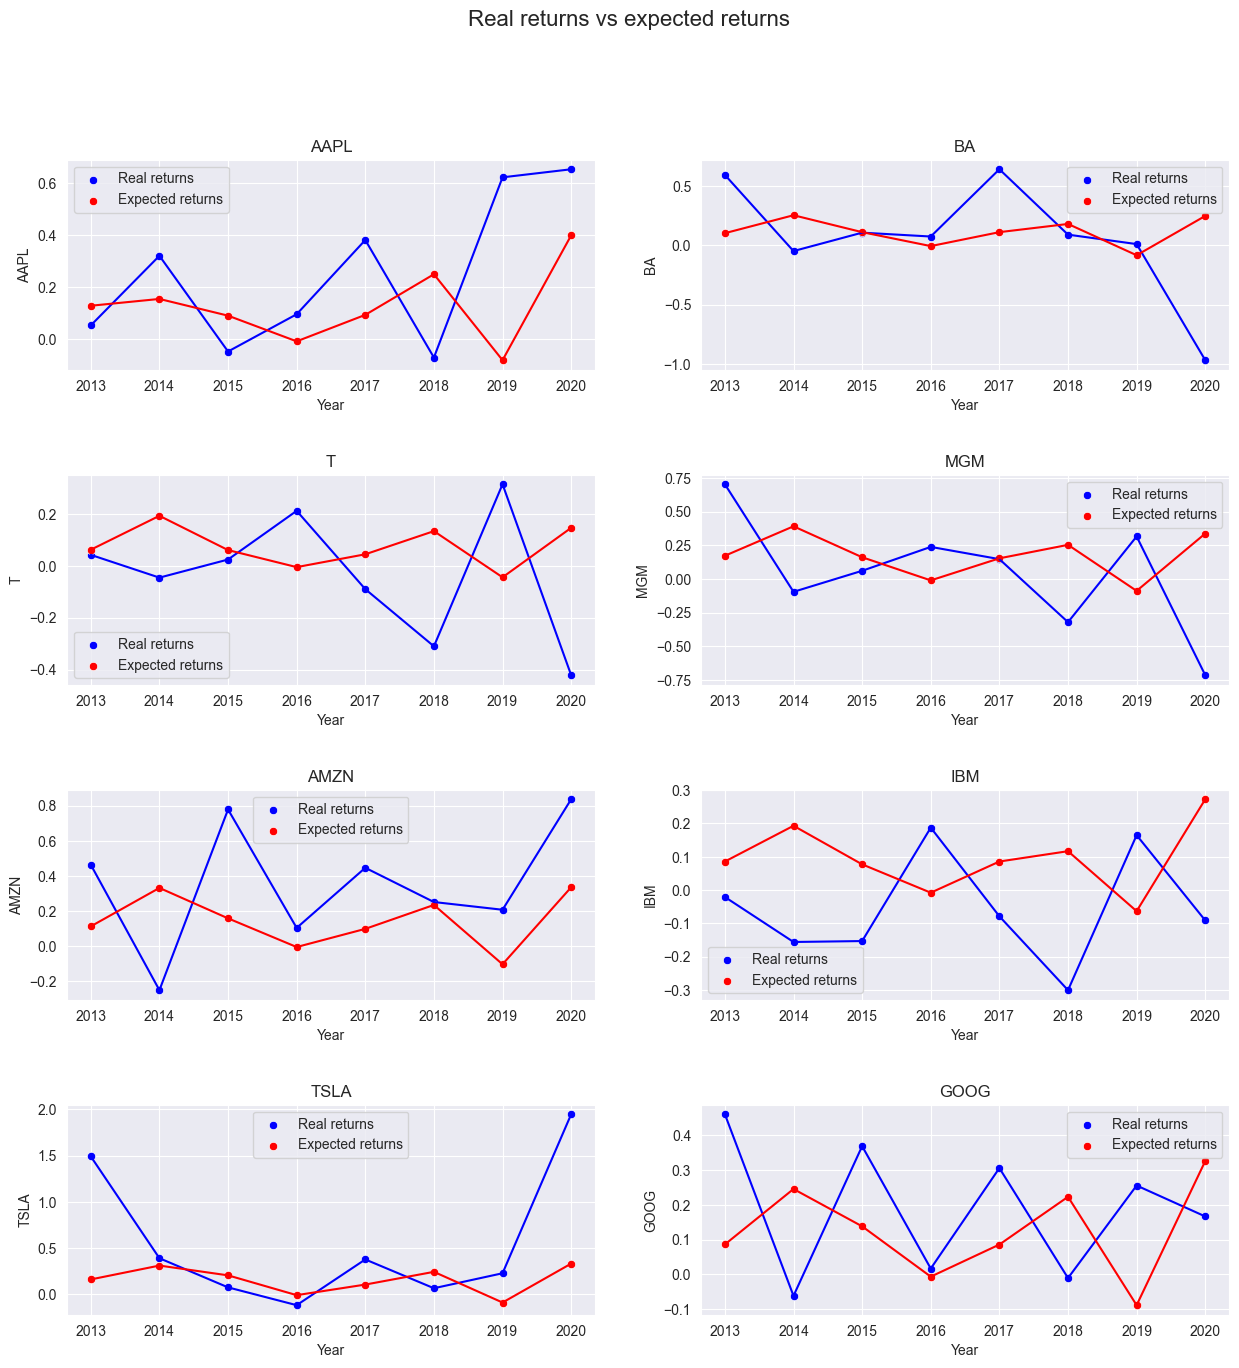

In [ ]:
# Compare real returns and expected returns

sns.set_style('darkgrid')

# Plot the scatterplots of the returns with respect to the sp500 in a 4x2 grid with the regression line
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Real returns vs expected returns', fontsize=16)

for i, col in enumerate(real_returns.columns[1:-1]):
    sns.scatterplot(x='Year', y=col, data=real_returns, ax=axes.flatten()[i], color='blue', label='Real returns')
    sns.lineplot(x='Year', y=col, data=real_returns, ax=axes.flatten()[i], color='blue')

    sns.scatterplot(x='Year', y=col, data=expected_returns, ax=axes.flatten()[i], color='red', label='Expected returns')
    sns.lineplot(x='Year', y=col, data=expected_returns, ax=axes.flatten()[i], color='red')

    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('Year')
    axes[i//2, i%2].set_ylabel(col)


plt.show()

### Comment

When real returns surpass expected returns, it indicates that *the stock is generating alpha*, signifying the stock's ability to outperform what is predicted by the CAPM. The graphical representation reaffirms earlier observations, highlighting IBM's underperformance and Tesla's strong performance, aligning with their respective alpha values. Notably, Google demonstrates an alpha close to zero, suggesting that, on average, its cumulative returns align with expected returns. However, within individual time periods, significant fluctuations are observed. This coherence can be linked to Google's lower R-squared compared to other companies, signifying that the CAPM model is not as effective in explaining the variability in Google's returns. The wider fluctuations in Google's returns underscore the influence of additional factors beyond beta and the market risk premium, contributing to this deviation from the expected.

These deviations between real and expected returns underscore the complexity of financial markets. Understanding these disparities aids in refining investment strategies, risk management approaches, and overall financial decision-making, allowing for a more nuanced and accurate view of how various factors shape returns in the real world.




In [ ]:
# Make interactive plots of the expected returns
fig = px.line(expected_returns, x='Year', y=expected_returns.columns[1:], title='Expected returns')
fig.show()

We see that the expected returns have all the same pattern, enhanced - or reduced - by a stock specific factor (the beta). This happens because the expected returns are computed with respect to the market expected return (minus the risk-free asset, assumed to be 0 in this application).

In [ ]:
b = []
fig = go.Figure()

# stocks = ['AAPL','BA','T','MGM','AMZN','IBM','TSLA','GOOG']
years_list = [2013,2014,2015,2016,2017,2018,2019,2020]

for stock in expected_returns.columns[1:]: # Exclude the date and sp500 columns (not in expected_returns df)
    stock_real = real_returns[stock].tolist()
    stock_expected = expected_returns[stock].tolist()

    # Add scatter plot for each stock
    fig.add_trace(go.Scatter(x=years_list, y=stock_real, mode='markers', name=f'{stock} Actual',
                            marker=dict(symbol='circle', size=10), text=stock))

    fig.add_trace(go.Scatter(x=years_list, y=stock_expected, mode='markers', name=f'{stock} Estimated',
                            marker=dict(symbol='circle', size=10), text=stock))

    true_falses = [s == stock for s in ['AAPL', 'AAPL', 'BA', 'BA', 'T', 'T', 'MGM', 'MGM', 'AMZN', 'AMZN', 'IBM', 'IBM', 'TSLA', 'TSLA', 'GOOG', 'GOOG']]

    b.append(dict(
                args=[{'visible': true_falses}, {'title': stock}],
                label=stock,
                method='update'
                ))

# Create a custom JavaScript function for on-click events
fig.update_layout(
    updatemenus=[
        dict(
            buttons=b,
            direction='down',
            showactive=True,
            x=0.13,
            xanchor='left',
            y=1.15,
            yanchor='top'
        )
    ])

# Update hover text
fig.update_traces(textposition='top center', hoverinfo='x+text')

fig.update_layout(
    title='Actual and Estimated Returns for Stocks',
    xaxis_title='Year',
    yaxis_title='Return',
    template='plotly_dark'
)

fig.show()

___

Add the risk-free rate

In [ ]:
tbills = pd.read_csv('./data/10-years-treasury-bills.csv').rename(columns={' value': 'value'})
tbills['date'] = pd.to_datetime(tbills['date'])
tbills['value'] = tbills['value']/100
tbills.head()

,date,value
0,1962-01-02,0.0406
1,1962-01-03,0.0403
2,1962-01-04,0.0399
3,1962-01-05,0.0402
4,1962-01-08,0.0403


In [ ]:
# Estimate the betas using a yearly dataframe

returns_df.Date = pd.to_datetime(returns_df.Date)

expected_returns_rf = pd.DataFrame()
real_returns_rf = pd.DataFrame()

years = returns_df.Date.dt.year.unique()[1:]

for year in years:

    # Compute the expected returns for the year
    returns_year_df = returns_df[returns_df.Date.dt.year == year -1]

    rf = float(tbills.value.mean())
    alpha, beta, significant_a, significant_b, reg_df = compute_ba(returns_year_df, rf=rf)
    rm = returns_year_df['sp500'].mean()*252

    estimated_rets = np.array(list(beta.values())) * (rm-rf) + np.array(list(alpha.values())) + rf
    expected_returns_rf[year] = pd.Series(estimated_rets, index=returns_year_df.columns[1:-1]) # Append the column to the dataframe and set the name

expected_returns_rf = expected_returns_rf.T.reset_index().rename(columns={'index': 'Year'})
expected_returns_rf

,Year,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
0,2013,0.112060,0.100697,0.084361,0.129645,0.105915,0.094003,0.125877,0.094405
1,2014,0.177937,0.255143,0.207551,0.361711,0.315377,0.207799,0.300992,0.248764
2,2015,0.100272,0.108822,0.085976,0.131799,0.130030,0.093312,0.153197,0.121308
3,2016,-0.016890,-0.006848,0.011210,-0.038882,-0.012159,-0.009137,-0.016110,-0.011089
4,2017,0.091813,0.098061,0.074773,0.113573,0.093832,0.089378,0.096129,0.089060
5,2018,0.226073,0.179981,0.147955,0.228591,0.216350,0.136614,0.222552,0.208408
6,2019,-0.095400,-0.102362,-0.025144,-0.109035,-0.139487,-0.061793,-0.108698,-0.109962
7,2020,0.365420,0.248790,0.171242,0.318090,0.316372,0.268230,0.314739,0.309107


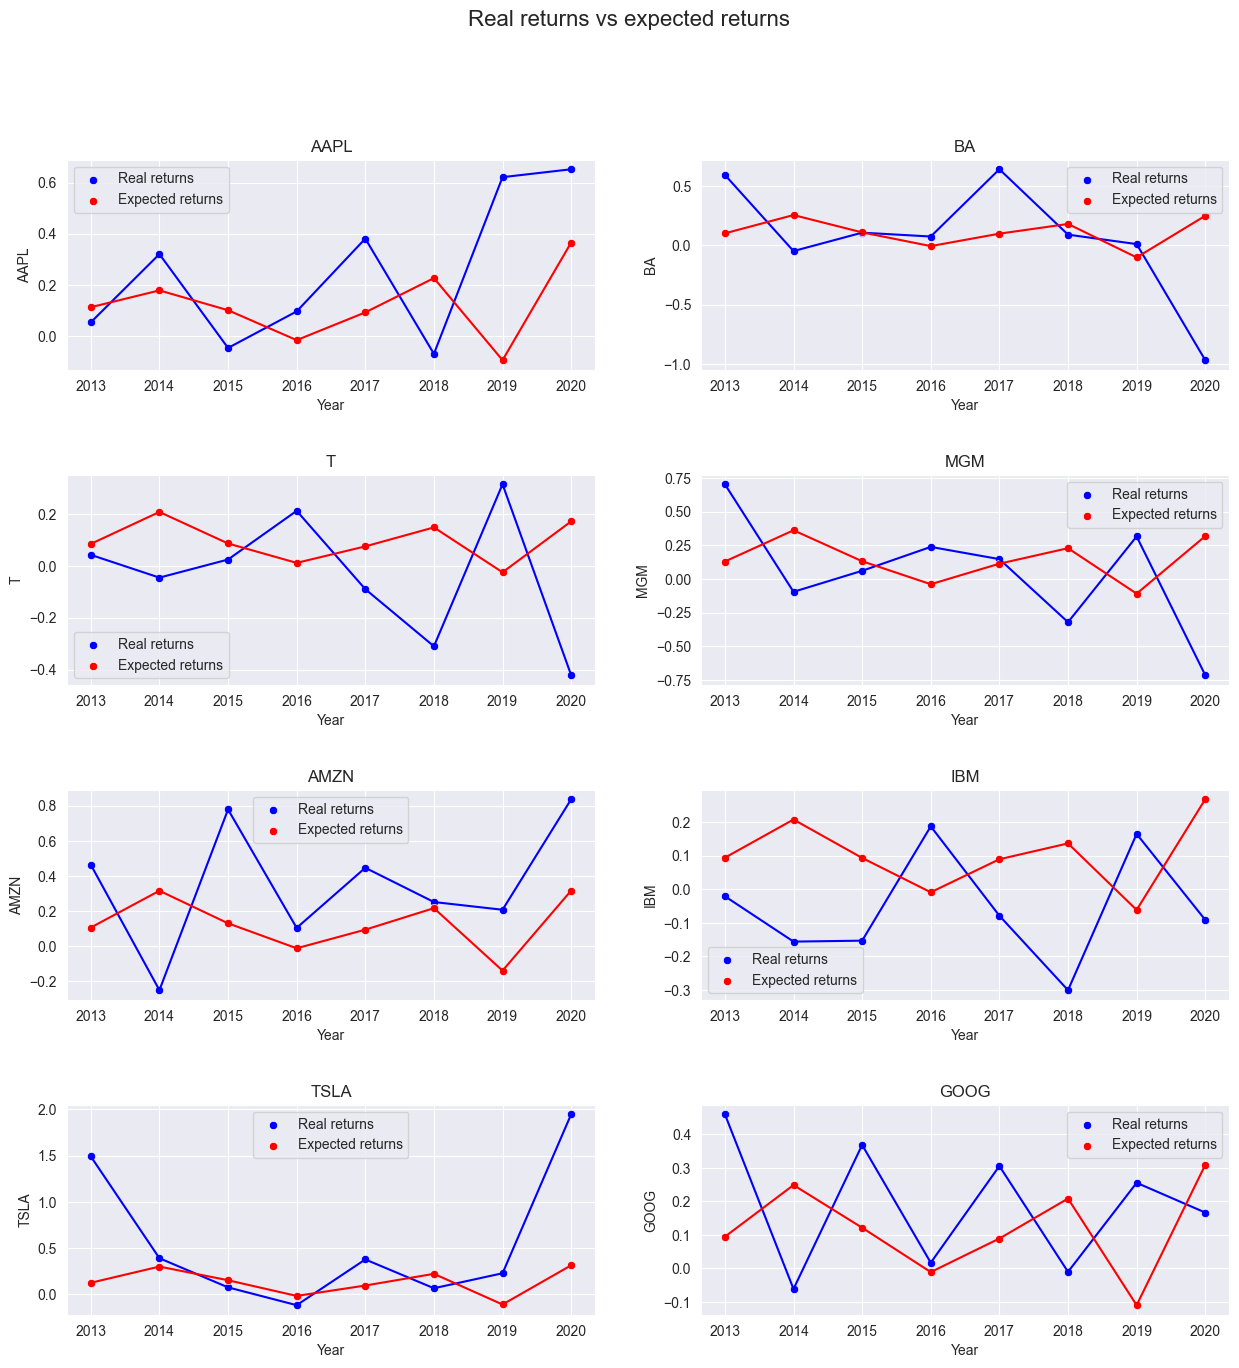

In [ ]:
# Compare real returns and expected returns

sns.set_style('darkgrid')

# Plot the scatterplots of the returns with respect to the sp500 in a 4x2 grid with the regression line
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Real returns vs expected returns', fontsize=16)

for i, col in enumerate(real_returns.columns[1:-1]):
    sns.scatterplot(x='Year', y=col, data=real_returns, ax=axes.flatten()[i], color='blue', label='Real returns')
    sns.lineplot(x='Year', y=col, data=real_returns, ax=axes.flatten()[i], color='blue')

    sns.scatterplot(x='Year', y=col, data=expected_returns_rf, ax=axes.flatten()[i], color='red', label='Expected returns')
    sns.lineplot(x='Year', y=col, data=expected_returns_rf, ax=axes.flatten()[i], color='red')

    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('Year')
    axes[i//2, i%2].set_ylabel(col)


plt.show()

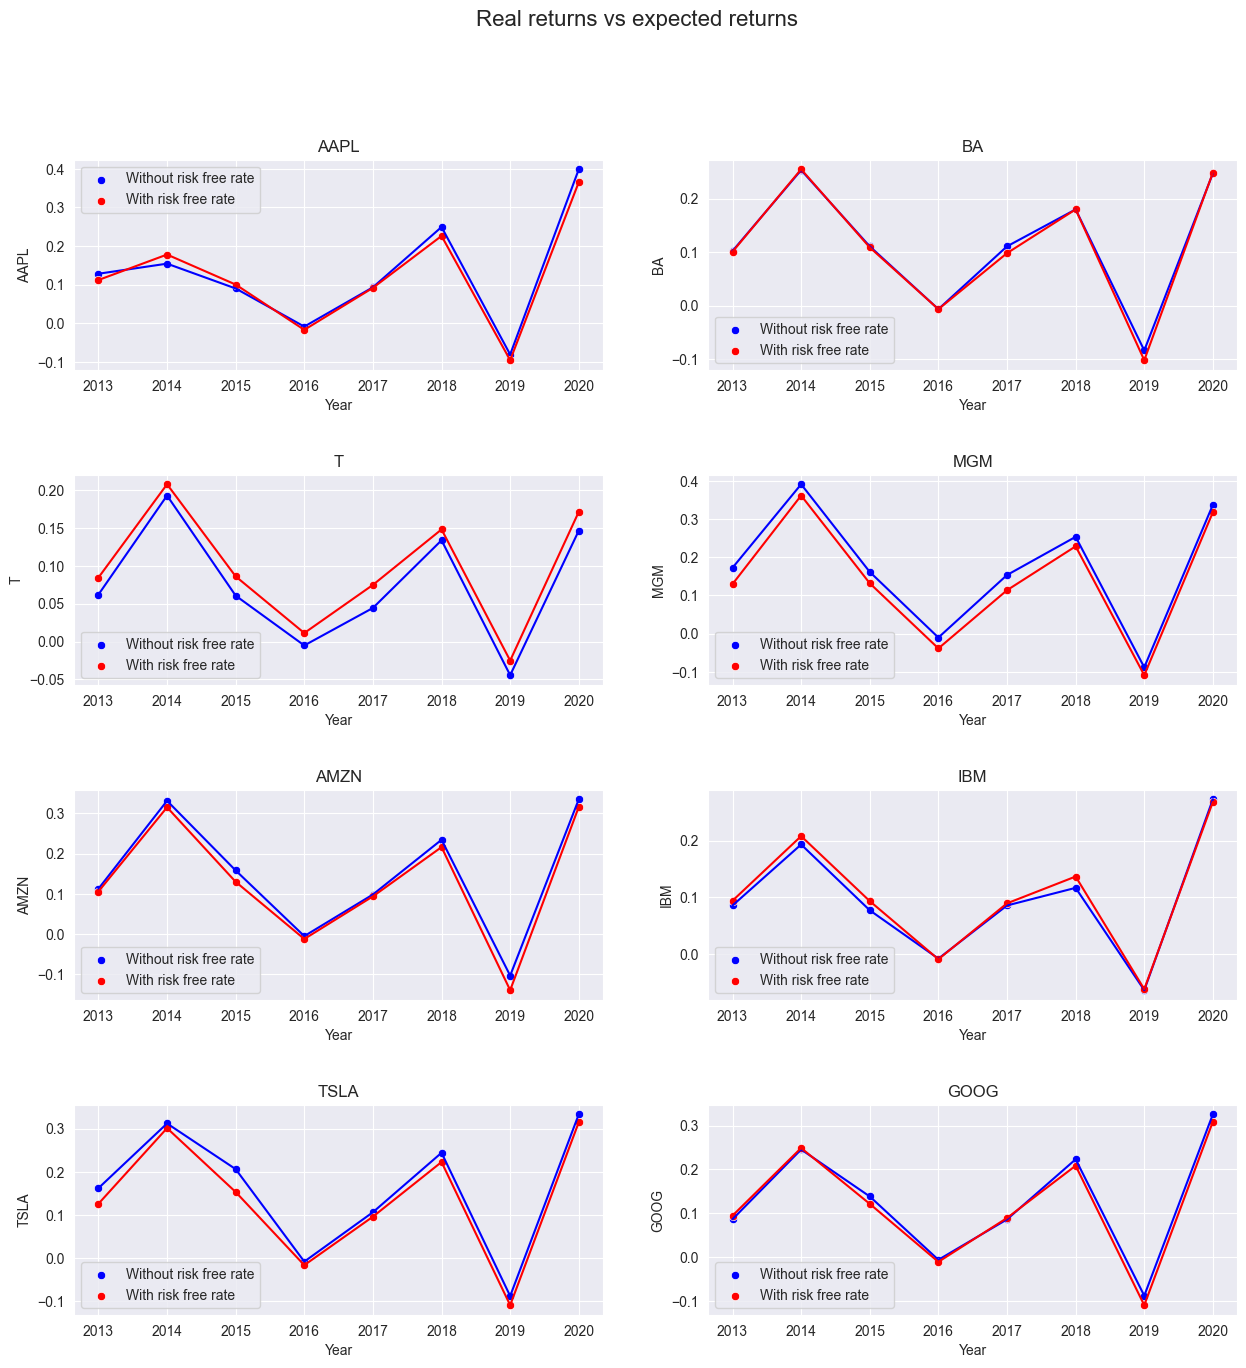

In [ ]:
# Compare the expected returns with and without the risk free rate

sns.set_style('darkgrid')

# Plot the scatterplots of the returns with respect to the sp500 in a 4x2 grid with the regression line
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Real returns vs expected returns', fontsize=16)

for i, col in enumerate(expected_returns.columns[1:]):
    sns.scatterplot(x='Year', y=col, data=expected_returns, ax=axes.flatten()[i], color='blue', label='Without risk free rate')
    sns.lineplot(x='Year', y=col, data=expected_returns, ax=axes.flatten()[i], color='blue')

    sns.scatterplot(x='Year', y=col, data=expected_returns_rf, ax=axes.flatten()[i], color='red', label='With risk free rate')
    sns.lineplot(x='Year', y=col, data=expected_returns_rf, ax=axes.flatten()[i], color='red')

    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('Year')
    axes[i//2, i%2].set_ylabel(col)


plt.show()

___
Expand the timeframe of the analysis each year

In [ ]:
# Estimate the betas using a yearly dataframe

returns_df.Date = pd.to_datetime(returns_df.Date)

expected_returns_timeframe = pd.DataFrame()
real_returns_timeframe = pd.DataFrame()

years = returns_df.Date.dt.year.unique()[1:]

returns_year_df = pd.DataFrame()

for year in years:

    # Compute the expected returns for the year
    timeframe_df = returns_df[returns_df.Date.dt.year == year -1]
    returns_year_df = pd.concat([returns_year_df, timeframe_df])

    rf = float(tbills.value.mean())
    alpha, beta, significant_a, significant_b, reg_df = compute_ba(returns_year_df, rf=rf)
    rm = returns_year_df['sp500'].mean()*252

    estimated_rets = np.array(list(beta.values())) * (rm-rf) + np.array(list(alpha.values())) + rf # Annualize the returns
    expected_returns_timeframe[year] = pd.Series(estimated_rets, index=returns_year_df.columns[1:-1]) # Append the column to the dataframe and set the name

expected_returns_timeframe = expected_returns_timeframe.T.reset_index().rename(columns={'index': 'Year'})
expected_returns_timeframe

,Year,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
0,2013,0.112060,0.100697,0.084361,0.129645,0.105915,0.094003,0.125877,0.094405
1,2014,0.180045,0.182258,0.142767,0.261218,0.204042,0.157762,0.238656,0.169118
2,2015,0.150824,0.157757,0.121892,0.215148,0.183346,0.134861,0.216115,0.158537
3,2016,0.116133,0.115718,0.096543,0.146628,0.127953,0.107188,0.140814,0.117805
4,2017,0.111116,0.113139,0.091277,0.140436,0.120910,0.103839,0.131257,0.111693
5,2018,0.123952,0.125260,0.098722,0.157845,0.134856,0.113068,0.146841,0.124115
6,2019,0.098320,0.099577,0.081826,0.113718,0.106735,0.090605,0.109706,0.099553
7,2020,0.123451,0.120674,0.094434,0.142791,0.132665,0.109773,0.136558,0.122926


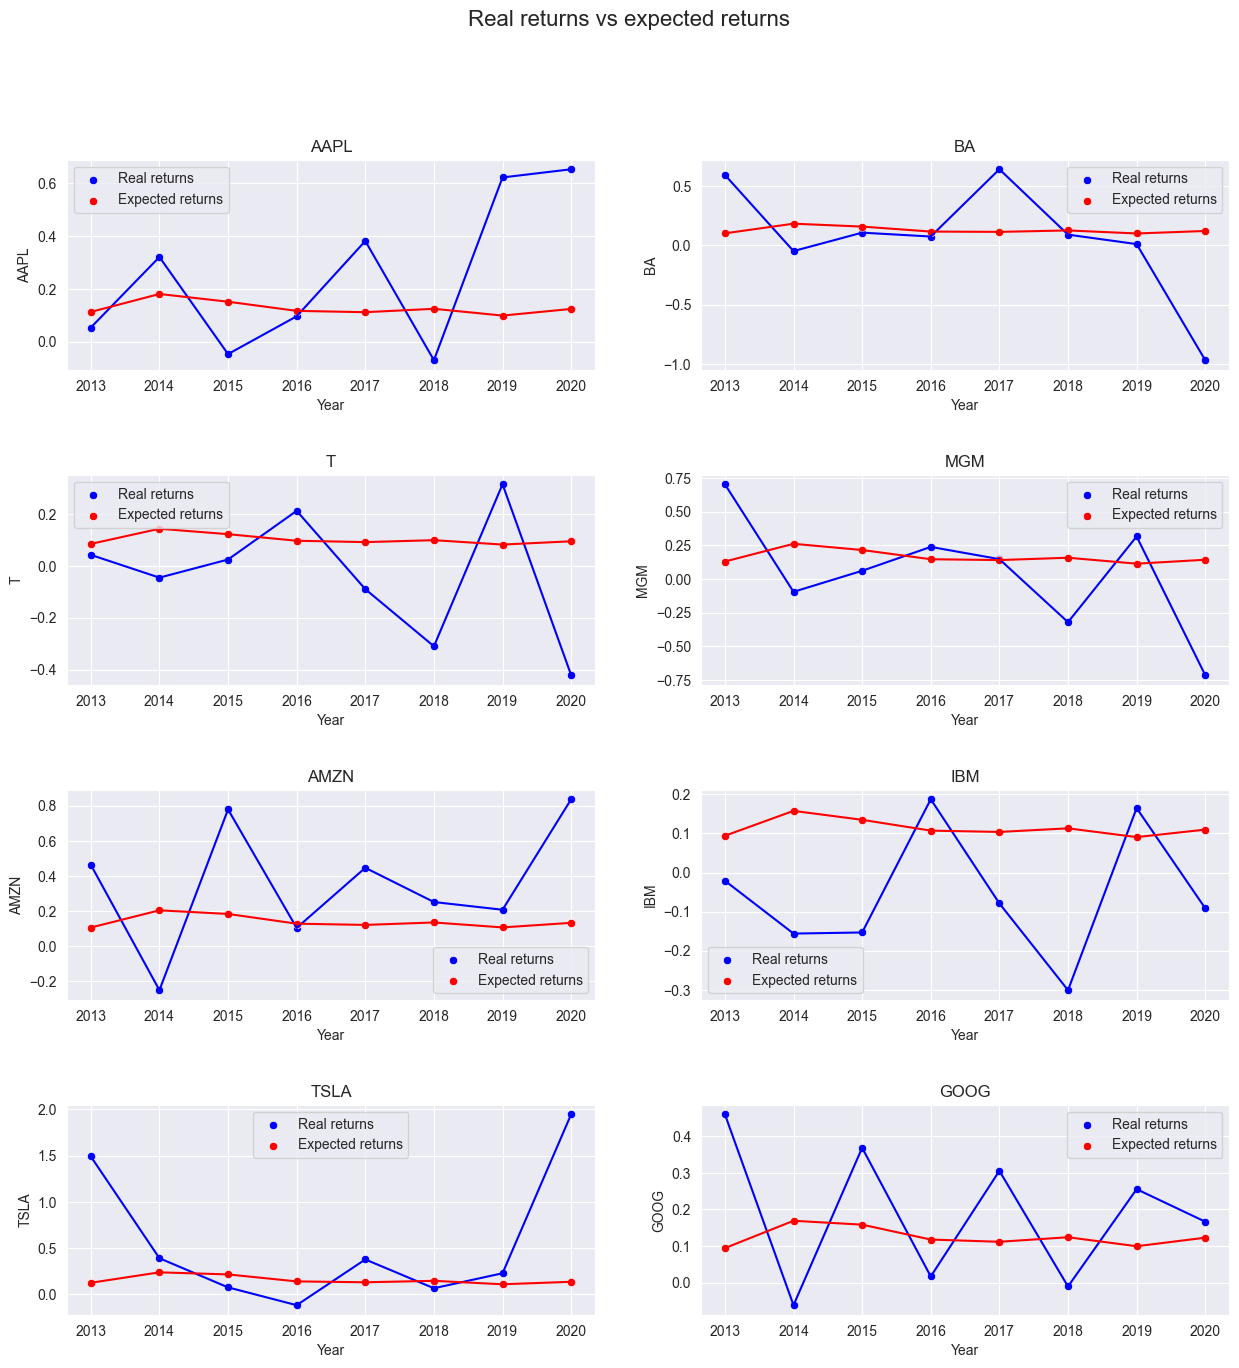

In [ ]:
# Compare real returns and expected returns

sns.set_style('darkgrid')

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Real returns vs expected returns', fontsize=16)

for i, col in enumerate(real_returns.columns[1:-1]):
    sns.scatterplot(x='Year', y=col, data=real_returns, ax=axes.flatten()[i], color='blue', label='Real returns')
    sns.lineplot(x='Year', y=col, data=real_returns, ax=axes.flatten()[i], color='blue')

    sns.scatterplot(x='Year', y=col, data=expected_returns_timeframe, ax=axes.flatten()[i], color='red', label='Expected returns')
    sns.lineplot(x='Year', y=col, data=expected_returns_timeframe, ax=axes.flatten()[i], color='red')

    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('Year')
    axes[i//2, i%2].set_ylabel(col)

Enlarging the timeframe of the analysis for the computation of the beta, we see that the expected returns are more stable and the beta is less volatile through the years.

In fact, according to the law of large numbers, the more data we have, the more stable the results are, so the variability of the beta is reduced.

# Task #4 (Optional)

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import yfinance as yf

In [ ]:
req = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(req.content, 'html.parser')
table = soup.find_all('a', {'class': 'external text'})
tickers = [i.text for i in table[:503]] # Because there are 503 stocks indexed in the S&P500
tickers.append('^GSPC') # Add the sp500 index

The function `sp500_tickers` takes three arguments: date1, date2 and tickers. `date1` is the start date of the period to analyze, `date2` is the end date and `tickers` is a list of the names of all the stocks for which data is needed.

In [ ]:
def sp500_tickers(date1, date2, tickers):
    ydata = yf.download(tickers, start=date1, end=date2, group_by='ticker')
    return ydata

In [ ]:
# date1 = '2012-01-01'
# date2 = '2020-12-31'

# ydata = sp500_tickers(date1, date2, tickers)
# ydata

In [ ]:
# ydata.to_csv('data_lab2_yahoo.csv')  #save data to csv

The data we can retrieve from Yahoo Finance's APIs is richer than the previous one we used for our analysis. For each stock, we have detailed information about:

- Open: The opening price of a stock on a given day.
- High: The highest price that a stock reaches on a given day.
- Low: The lowest price that a stock reaches on a given day.
- Close: The closing price of a stock on a given day.
- Adjusted Close: The closing price adjusted for corporate actions such as stock splits, dividends, and mergers.
- Volume: The number of shares of a stock that are traded on a given day.

This data gives us a better overview of the price variations for different stocks. For example, we can use the high and low prices for each day to calculate a measure of daily volatility, which gives us a better understanding of how volatile a stock's price is on a daily basis, rather than just looking at the open and close prices.

Adjusted close prices give us a more accurate picture of a stock's price performance over time, as they take into account corporate actions that can make relevant changes in close prices. For example, if a stock splits 2 for 1, the close price will be halved. The result is that the close price is not directly comparable to previous close prices. By using adjusted close prices, the split is taken into account and the stock's price history is more accurate.

In [ ]:
data_yahoo = pd.read_csv('./data/data_lab2_yahoo.csv', header=[0,1], index_col=[0], parse_dates=True)
data_yahoo.head()

RMD                                                       \
                 Open       High        Low      Close  Adj Close   Volume   
Date                                                                         
2012-01-03  25.750000  26.120001  25.570000  25.610001  21.741835   891800   
2012-01-04  25.440001  25.440001  24.969999  24.980000  21.206985  1080400   
2012-01-05  24.760000  24.900000  24.410000  24.809999  21.062660  1219800   
2012-01-06  24.959999  25.070000  24.820000  24.920000  21.156046   825200   
2012-01-09  25.010000  25.020000  24.600000  24.820000  21.071156   663400   

              AES                       ...        PLD                        \
             Open   High    Low  Close  ...        Low      Close  Adj Close   
Date                                    ...                                    
2012-01-03  12.03  12.21  11.85  12.12  ...  28.730000  29.240000  20.689528   
2012-01-04  12.05  12.20  12.01  12.03  ...  28.230000  28.500000  20.165922   
2012-01-05  12.02  12.38  11.90  12.32  ...  28.160000  29.240000  20.689528   
2012-01-06  12.28  12.38  12.14  12.23  ...  28.600000  28.790001  20.371115   
2012-01-09  12.23  12.51  12.17  12.47  ...  28.459999  28.530001  20.187143   

                          MSCI                                              \
             Volume       Open       High        Low      Close  Adj Close   
Date                                                                         
2012-01-03  3104800  33.889999  33.889999  32.680000  32.810001  29.726990   
2012-01-04  3068000  32.630001  32.740002  32.250000  32.349998  29.310211   
2012-01-05  4350600  32.270000  32.759998  32.000000  32.720001  29.645451   
2012-01-06  3674100  32.580002  33.279999  32.360001  33.099998  29.989737   
2012-01-09  1987300  33.340000  33.470001  32.889999  32.970001  29.871946   

                    
            Volume  
Date                
2012-01-03  763700  
2012-01-04  760000  
2012-01-05  491000  
2012-01-06  511100  
2012-01-09  421800  

[5 rows x 3024 columns]

In [ ]:
# Null values
print(f'Number of null values: {data_yahoo.isnull().sum().sum()}')

Number of null values: 316800


We did not address the null values because our analysis was primarily focused on the previously analyzed stocks, for which we had complete data.


### Daily variations per Analysis

In [ ]:
#adding a column to analize maximum daily volatility
for i in data_yahoo.columns.levels[0]:
    data_yahoo[i,'daily_vol'] = data_yahoo[i,'High'] - data_yahoo[i,'Low']
data_yahoo.sort_index(axis=1, level=[0, 1], inplace=True)

In [ ]:
#get basics statistics for each stock
mean_vol= data_yahoo.xs('daily_vol', axis=1, level=1).mean()
var_vol = data_yahoo.xs('daily_vol', axis=1, level=1).var()
std_vol = data_yahoo.xs('daily_vol', axis=1, level=1).std()

#normalize the daily volatility
daily_vol = data_yahoo.xs('daily_vol', axis=1, level=1)
norm_vol = (daily_vol - mean_vol)/mean_vol

#our prior stocks
selected_stocks = data.columns[1:-1].to_list()


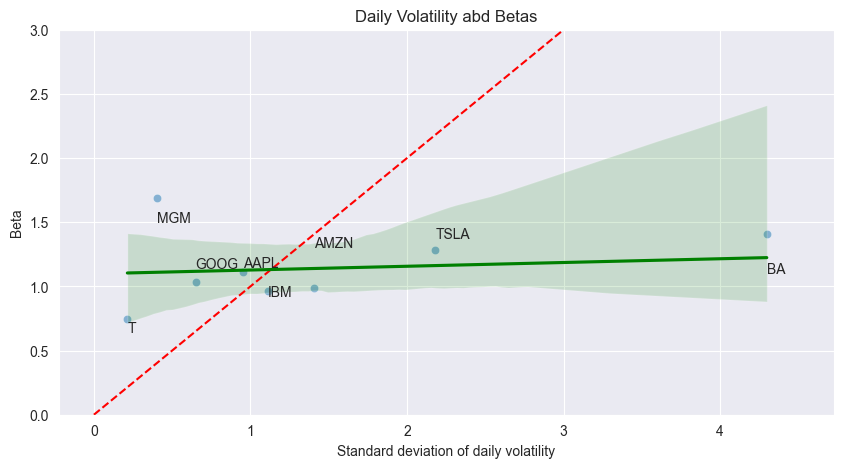

In [ ]:
previous_values = compute_ba(returns_df)
sns.set_style('darkgrid')
plt.figure(figsize=(10,5))
sns.scatterplot(x=std_vol[selected_stocks], y=previous_values[4]['Beta'], alpha=0.5)

# Plot a 45 degree line
plt.plot([0, 4.5], [0, 4.5], color='red', linestyle='--')

# Plot the regression line
sns.regplot(x=std_vol[selected_stocks], y=reg_df['Beta'], scatter=False, color='green')

# Add annotations
for i, txt in enumerate(std_vol[selected_stocks].index):
    plt.annotate(txt, (std_vol[selected_stocks][i], reg_df['Beta'][i]))

plt.ylim(0, 3)
plt.title('Daily Volatility abd Betas')
plt.xlabel('Standard deviation of daily volatility')
plt.show()

### Comments:
Since the actual daily volatility of stock prices may be hidden by the opening and closing prices, we investigated whether there is a correlation between the betas of stocks and the standard deviation of daily volatility, which is a measure of how volatile a stock's price is on a daily basis. As shown in the graph above, there is no discernible correlation between the betas of the stocks analyzed and their actual standard deviation of daily volatility. The Boeing stocks driving the regression line to be even more flat, with a standard deviation of over 4 and a beta of around 1.4.

### Absolute and normalized daily volatility
With daily volatility computed as the difference between Highs and Lows for every day.


In [ ]:
#daily plotted
fig = go.Figure()
for stock in selected_stocks:
    fig.add_trace(go.Histogram(x=daily_vol[stock], name=stock))
    fig.update_layout(
        title='Volatility of the selected stocks',
        xaxis_title='Daily volatility',
        yaxis_title='Frequency',
        template='plotly_dark'
    )
fig.show()



In [ ]:
#normalized plot
fig = go.Figure()
for stock in selected_stocks:
    fig.add_trace(go.Histogram(x=norm_vol[stock], name=stock))
    fig.update_layout(
        title='Volatility of the selected stocks',
        xaxis_title='Normalized daily volatility',
        yaxis_title='Frequency',
        template='plotly_dark'
    )
fig.show()

### Comments on the distributions of daily volatility, with absolute and normalized values

We have decided to plot both the absolute and normalized values distributions because:

- The absolute distribution shows the actual range of variations for each stock individually.
- The normalized distribution allows us to compare stocks because the variations are calculated relative to the mean variation. This allows us to see which stocks have a wider or narrower range of volatility.

In the graph above, we can see that the absolute and normalized distributions overlap in the highest frequency region for most of the stocks. This means that the stocks have similar volatility levels most of the time. However, there is some difference in the tails of the distributions, indicating that some stocks have experienced more high-volatility days than others.

In [ ]:
selected_stocks.append('^GSPC')
adj_close_data = data_yahoo.xs('Adj Close', axis=1, level=1)[selected_stocks]
adj_close_data.reset_index(inplace=True)
adj_close_data.rename(columns={'^GSPC': 'sp500'}, inplace=True)
adj_close_data.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-03,12.466093,60.731098,9.619624,10.493510,8.9515,114.206635,1.872000,16.573130,1277.060059
1,2012-01-04,12.533086,60.821102,9.635457,10.427397,8.8755,113.740723,1.847333,16.644611,1277.300049
2,2012-01-05,12.672230,60.166477,9.625957,10.512402,8.8805,113.201225,1.808000,16.413727,1281.060059
3,2012-01-06,12.804699,60.534714,9.581588,10.512402,9.1305,111.901627,1.794000,16.189817,1277.810059
4,2012-01-09,12.784394,60.984756,9.575134,10.691857,8.9280,111.319199,1.816667,15.503389,1280.699951


In [ ]:
#min and max dates of the previous data
min_date = data['Date'].min()
max_date = data['Date'].max()
print('In the previous data, the minimum date is: ', min_date, ' and the maximum date is: ', max_date)

In the previous data, the minimum date is:  2012-01-12  and the maximum date is:  2020-08-11


In [ ]:
# filter the data
adj_close_data = adj_close_data.loc[(adj_close_data['Date'] >= min_date) & (adj_close_data['Date'] <= max_date)]
returns_adj = compute_returns(adj_close_data)
returns_adj.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
7,2012-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2012-01-13,-0.003756,-0.012125,-0.001661,0.017974,0.014054,-0.007728,-0.214772,-0.007413,-0.004960
9,2012-01-17,0.011581,0.008543,0.005968,-0.008130,0.017997,0.004678,0.154589,0.005728,0.003547
10,2012-01-18,0.010330,-0.002395,0.002641,0.038435,0.041936,0.005927,0.007864,0.006865,0.011047
11,2012-01-19,-0.003174,0.006639,0.002963,0.005484,0.026103,-0.003042,-0.001867,0.010468,0.004927


In [ ]:
#computing alphas and betas
adj_values = compute_ba(returns_adj)
previous_values = compute_ba(returns_df)

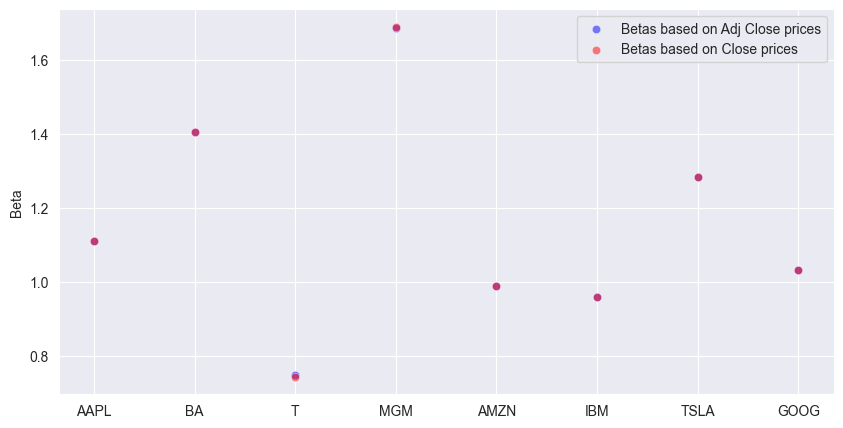

In [ ]:
#plotting previous betas vs new betas for every stock on the x axis

sns.set_style('darkgrid')
plt.figure(figsize=(10,5))
sns.scatterplot(x=adj_values[4].index, y=adj_values[4]['Beta'], color='blue', alpha=0.5, label='Betas based on Adj Close prices')
sns.scatterplot(x=previous_values[4].index, y=previous_values[4]['Beta'], color='red', alpha=0.5, label='Betas based on Close prices')
plt.legend()

In [ ]:
#Difference between the betas
diff_betas = adj_values[4]['Beta'] - previous_values[4]['Beta']
diff_betas

AAPL   -3.243237e-04
BA     -1.608996e-03
T       4.034688e-03
MGM    -2.933352e-03
AMZN    1.094123e-07
IBM    -1.563666e-03
TSLA   -4.934919e-09
GOOG   -1.450563e-07
Name: Beta, dtype: float64

### Comments on betas differences:

To check if there were substantial differences between the closing prices and the adjusted prices, we conducted a comparative analysis of betas calculated using the two different measures. This is important because corporate actions can severely affect stock prices, but may not affect the normal closing prices. As a result, calculating betas using closing prices and using CAPM to estimate stock returns could produce inaccurate results. However, the comparison of betas calculated using the two measures shows that there is no significant difference between them, with only a few cents difference in some cases. This makes the previous analysis more reliable and is reasonable since our betas are estimated over a long period of time making corporate action absorbed by the time.